In [221]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [222]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
import math
import cv2 as cv
import copy
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import Sequence
from keras import optimizers
import pylab
from sklearn.metrics import accuracy_score
import h5py
import skimage
from skimage import transform
from keras.utils import CustomObjectScope
from keras.models import load_model
from keras import applications
from scipy import ndimage



In [223]:
Train_data = pd.read_csv('train_v2.csv')

In [224]:
Train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [225]:
train_ids = Train_data['image_name'].tolist()

In [227]:
num_train = len(train_ids)
num_train

40479

In [228]:
train_labels = Train_data['tags'].tolist()
train_labels = list(map(lambda x: x.split(' '), train_labels))
labels = [label for label_list in train_labels for label in label_list ]
labels = list(set(labels))

In [233]:
labels

['cloudy',
 'bare_ground',
 'blow_down',
 'habitation',
 'cultivation',
 'slash_burn',
 'artisinal_mine',
 'conventional_mine',
 'blooming',
 'road',
 'water',
 'selective_logging',
 'primary',
 'clear',
 'agriculture',
 'partly_cloudy',
 'haze']

In [234]:
num_labels = len(labels)
num_labels

17

In [235]:
label_dict = {label:num for label,num in zip(labels,range(len(labels)))}
string_to_int = lambda x: label_dict[x]
string_list_to_ints = lambda li: list(map(string_to_int, li))
train_labels =list(map(string_list_to_ints,train_labels))

In [241]:
def encode_labels(label_list):
    label_list = np.array(list(map(lambda x: np.eye(num_labels)[x],label_list)))
    label_list = np.sum(label_list,axis=0)
    return label_list

In [242]:
train_labels = list(map(encode_labels,train_labels))
train_labels = np.array(train_labels)

In [244]:
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [246]:
trn_ids,val_ids,trn_labels,val_labels = train_test_split(train_ids,train_labels,test_size=0.1)

In [247]:
num_trn = len(trn_ids); num_val = len(val_ids);
num_trn,num_val, num_train * 0.9, num_train * 0.1

(36431, 4048, 36431.1, 4047.9)

In [249]:
train_path = './train-jpg/'

In [255]:
IMG_H, IMG_W, NUM_C = 256, 256, 3

(256, 256, 3)

In [257]:
mean_all=np.array([0.485, 0.456, 0.406]) ; std_all=np.array([0.229, 0.224, 0.225])

In [259]:
class train_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_label(indx)
       
    
    def get_label(self,indx):
        
        return trn_labels[indx]
    
    def get_img(self,indx):
        img = mpimg.imread(train_path+trn_ids[indx]+'.jpg')
        img = img[:,:,0:3]
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_trn

In [260]:
class valid_ds():
    
    def __init__(self):
        return
    
    def __getitem__(self,indx):
        return self.get_img(indx),self.get_label(indx)
       
    
    def get_label(self,indx):
        
        return val_labels[indx]
    
    def get_img(self,indx):
        img = mpimg.imread(train_path+val_ids[indx]+'.jpg')
        img = img[:,:,0:3]
        img = (img-mean_all)/std_all
        return img
        
    
    def __len__(self):
        return num_val

In [261]:
trn_ds = train_ds() 
val_ds = valid_ds()

In [264]:
class train_dl(Sequence):
    def __init__(self,bs=4):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
    
    def on_epoch_end(self):
        self.indices = np.split(np.random.permutation(self.num_img),self.num_batch)
        
        
        
    def __len__(self):
        return num_trn // self.bs
    
    def __getitem__(self,indx):
        batch = [trn_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask
    
  

In [265]:
class valid_dl(Sequence):
    def __init__(self,bs=4):
        self.bs = bs
        self.num_batch = len(self)
        self.num_img = self.bs * self.num_batch
        self.indices = np.split(np.arange(0,self.num_img),self.num_batch)
        
    def __len__(self):
        return num_val // self.bs
    
    def __getitem__(self,indx):
        batch = [val_ds[i] for i in self.indices[indx]]
        batch_img = np.array([data[0] for data in batch])
        batch_mask = np.array([data[1] for data in batch])
        return batch_img,batch_mask

In [269]:
def make_resnet():
    
    data = layers.Input(shape=(IMG_H,IMG_W,NUM_C))
    
    base = applications.resnet50.ResNet50(include_top = False, weights = 'imagenet',pooling='avg' )(data)
     
    top = layers.Dense(num_labels,activation='sigmoid',use_bias = True,kernel_initializer='he_normal', 
                       bias_initializer = 'zeros')(base)
    
    resnet = Model(inputs = data, outputs = top)
    
    return resnet

In [270]:
resnet = make_resnet()

In [271]:
resnet.get_layer(index=1).trainable = False

In [272]:
optimizer = optimizers.Adam(lr=0.001)

In [273]:
resnet.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])

In [274]:
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
resnet.fit_generator(trn_dl_fit,epochs=1,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/1
2276/2276 [==============================] - 241s 106ms/step - loss: 0.1468 - acc: 0.9449 - val_loss: 0.7720 - val_acc: 0.8311


In [275]:
resnet.get_layer(index=1).trainable = True

In [276]:
optimizer = optimizers.Adam(lr=0.001)

In [277]:
resnet.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])

In [278]:
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
resnet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/5
2276/2276 [==============================] - 733s 322ms/step - loss: 0.1441 - acc: 0.9443 - val_loss: 0.1919 - val_acc: 0.9250
Epoch 2/5
2276/2276 [==============================] - 715s 314ms/step - loss: 0.1168 - acc: 0.9551 - val_loss: 0.2041 - val_acc: 0.9153
Epoch 3/5
2276/2276 [==============================] - 716s 315ms/step - loss: 0.1084 - acc: 0.9584 - val_loss: 0.1681 - val_acc: 0.9333
Epoch 4/5
2276/2276 [==============================] - 717s 315ms/step - loss: 0.1018 - acc: 0.9606 - val_loss: 0.1459 - val_acc: 0.9400
Epoch 5/5
2276/2276 [==============================] - 717s 315ms/step - loss: 0.0966 - acc: 0.9625 - val_loss: 0.2003 - val_acc: 0.9257


In [478]:
#resnet.save('resnet_top_lr_p001_epoch_1_all_lr_p001_epoch_5_v2.h5') 

In [338]:
#resnet = load_model('resnet_top_lr_p001_epoch_1_all_lr_p001_epoch_5_v2.h5')

In [279]:
optimizer = optimizers.Adam(lr=0.0001)
resnet.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
resnet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/5
2276/2276 [==============================] - 735s 323ms/step - loss: 0.0799 - acc: 0.9690 - val_loss: 0.0953 - val_acc: 0.9642
Epoch 2/5
2276/2276 [==============================] - 715s 314ms/step - loss: 0.0739 - acc: 0.9713 - val_loss: 0.0940 - val_acc: 0.9655
Epoch 3/5
2276/2276 [==============================] - 718s 315ms/step - loss: 0.0691 - acc: 0.9732 - val_loss: 0.0950 - val_acc: 0.9654
Epoch 4/5
2276/2276 [==============================] - 718s 316ms/step - loss: 0.0643 - acc: 0.9750 - val_loss: 0.1039 - val_acc: 0.9623
Epoch 5/5
2276/2276 [==============================] - 718s 315ms/step - loss: 0.0594 - acc: 0.9769 - val_loss: 0.1010 - val_acc: 0.9648


In [480]:
#resnet.save('resnet_top_lr_p001_epoch_1_all_lr_p001_epoch_5_lr_p0001_epoch_5_v2.h5')

In [280]:
optimizer = optimizers.Adam(lr=0.00001)
resnet.compile(optimizer=optimizer,loss='binary_crossentropy', metrics = ['accuracy'])
trn_dl_fit=train_dl(bs=16)
val_dl_fit=valid_dl(bs=16)
resnet.fit_generator(trn_dl_fit,epochs=5,validation_data=val_dl_fit,shuffle=False,workers=8)

Epoch 1/5
2276/2276 [==============================] - 737s 324ms/step - loss: 0.0520 - acc: 0.9798 - val_loss: 0.1034 - val_acc: 0.9652
Epoch 2/5
2276/2276 [==============================] - 719s 316ms/step - loss: 0.0507 - acc: 0.9803 - val_loss: 0.1054 - val_acc: 0.9648
Epoch 3/5
2276/2276 [==============================] - 720s 316ms/step - loss: 0.0495 - acc: 0.9808 - val_loss: 0.1063 - val_acc: 0.9645
Epoch 4/5
2276/2276 [==============================] - 720s 316ms/step - loss: 0.0487 - acc: 0.9812 - val_loss: 0.1075 - val_acc: 0.9647
Epoch 5/5
2276/2276 [==============================] - 720s 316ms/step - loss: 0.0475 - acc: 0.9817 - val_loss: 0.1093 - val_acc: 0.9644


In [281]:
resnet.save('resnet_top_lr_p001_epoch_1_all_lr_p001_epoch_5_lr_p0001_epoch_5_lr_p00001_epoch_5_v3.h5')

In [287]:
def plot_val(indx,TTA=False):
    val_im = val_ds[indx][0]
    val_label = val_ds[indx][1]
    val_im_plot = val_im * std_all + mean_all
    val_im_plot = val_im_plot.astype('int')
    plt.figure('val_im')
    plt.imshow(val_im_plot)
    if TTA is True:
        val_im_lr = np.fliplr(val_im)
        val_im_ud = np.flipud(val_im)
        val_im_lrud = np.fliplr(np.flipud(val_im))
        val_prob = resnet.predict(np.array([val_im]))[0] + resnet.predict(np.array([val_im_lr]))[0] \
        + resnet.predict(np.array([val_im_ud]))[0] + resnet.predict(np.array([val_im_lrud]))[0]    
        val_prob = val_prob/4.0
    else: 
        val_prob = resnet.predict(np.array([val_im]))[0] 
    val_pred = val_prob > 0.5
    print('pred:',[labels[indx] for indx in np.where(val_pred>0)[0]])
    print('label:',[labels[indx] for indx in np.where(val_label>0)[0]])

pred: ['primary', 'clear']
label: ['primary', 'clear']
1585


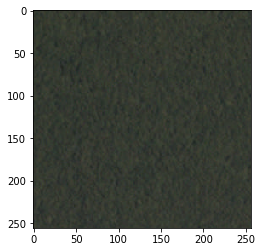

In [284]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary', 'partly_cloudy']
label: ['primary', 'partly_cloudy']
2592


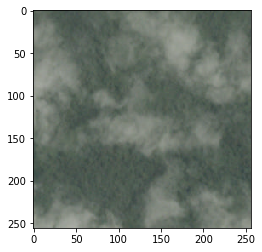

In [286]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['road', 'primary', 'agriculture', 'partly_cloudy']
label: ['cultivation', 'road', 'primary', 'agriculture', 'partly_cloudy']
44


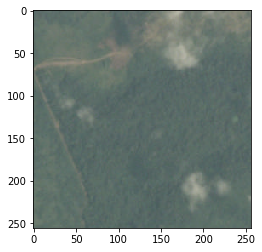

In [293]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['habitation', 'cultivation', 'road', 'primary', 'clear', 'agriculture']
label: ['habitation', 'cultivation', 'road', 'primary', 'clear', 'agriculture']
3746


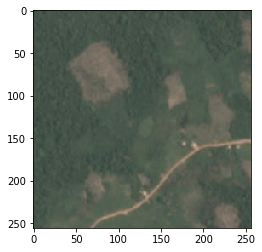

In [294]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['cultivation', 'primary', 'agriculture', 'partly_cloudy']
label: ['cultivation', 'slash_burn', 'primary', 'partly_cloudy']
1998


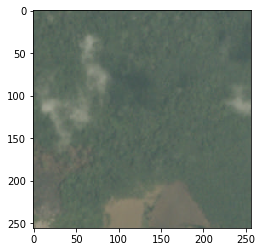

In [295]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['primary', 'clear', 'agriculture']
label: ['road', 'primary', 'clear', 'agriculture']
3919


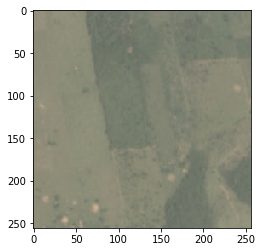

In [299]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['cultivation', 'water', 'primary', 'clear']
label: ['cultivation', 'water', 'primary', 'agriculture', 'partly_cloudy']
1206


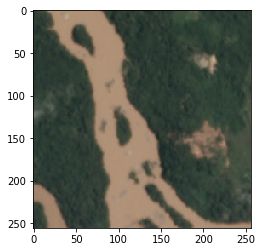

In [307]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)

pred: ['road', 'water', 'primary', 'agriculture', 'haze']
label: ['road', 'water', 'primary', 'agriculture', 'haze']
2823


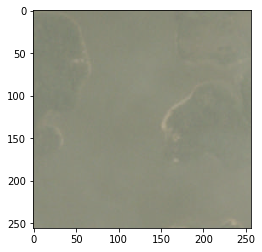

In [308]:
indx = np.random.randint(num_val)
plot_val(indx)
print(indx)